In [25]:
import json

import openeo
from openeo.processes import ProcessBuilder, lt, if_
from pg_to_evalscript import convert_from_process_graph
from sentinelhub import BBox, CRS, DownloadRequest, SentinelHubDownloadClient, MimeType, SHConfig
import numpy as np
import matplotlib.pyplot as plt

In [26]:
c = openeo.connect("https://openeo.vito.be/openeo/1.0")

In [27]:
test_polygon = {
    "type": "Polygon",
    "coordinates": [
        [
            [12.481616, 42.016518],
            [12.437678, 41.995082],
            [12.542031, 41.942992],
            [12.632654, 41.971595],
            [12.620297, 42.002228],
            [12.481616, 42.016518],
        ]
    ],
}

In [28]:
def mask(value: ProcessBuilder):
    red = value.array_element(0)
    nir = value.array_element(1)
    clm = value.array_element(2)

    ndvi = (nir - red) / (nir + red)

    return if_(lt(clm, 40), ndvi)

sen2cor = c.load_collection(
    "SENTINEL2_L2A_SENTINELHUB", bands=["B04", "B08", "CLP"], temporal_extent=["2020-01-01", "2021-01-01"]
)
sen2cor_masked = sen2cor.reduce_dimension(dimension="bands", reducer=mask)
sen2cor_masked = sen2cor_masked.aggregate_spatial(test_polygon, reducer="median")
process_graph = json.loads(sen2cor_masked.to_json())["process_graph"]

In [29]:
evalscripts = convert_from_process_graph(process_graph)
print(evalscripts)

[{'evalscript': <pg_to_evalscript.evalscript.Evalscript object at 0x000001ABA779CA00>, 'invalid_node_id': 'aggregatespatial1'}]


The output of `convert_from_process_graph` is a list of valid subgraphs. `aggregate_spatial` reduces by spatial coordinates, which is not possible to perform with Processing API, as it works per pixel. Therefore, it returns the subgraph which stops at the `aggregatespatial1` node.

In [30]:
evalscript = evalscripts[0]["evalscript"]
evalscript_string = evalscript.write()
print(evalscript_string)


//VERSION=3
function setup() {
  return {
    input: ['B04','B08','CLP'],
    output: { bands: 1, sampleType: "FLOAT32" },
    mosaicking: "ORBIT"
  };
}

function updateOutput(outputs, collection) {
    Object.values(outputs).forEach((output) => {
        output.bands = 1 + 1 * collection.scenes.length;
    });
}
class DataCube {
    constructor(data, bands_dimension_name, temporal_dimension_name, fromSamples) {
        this.TEMPORAL = "temporal"
        this.BANDS = "bands"
        this.OTHER = "other"
        this.bands_dimension_name = bands_dimension_name;
        this.temporal_dimension_name = temporal_dimension_name;
        this.dimensions = [{
            name: this.temporal_dimension_name,
            labels: [],
            type: this.TEMPORAL
        }, {
            name: this.bands_dimension_name,
            labels: [],
            type: this.BANDS
        }]
        if (fromSamples) {
            this.data = this.makeArrayFromSamples(data)
        } else {
            

In [31]:
config = SHConfig()
CLIENT_ID=
CLIENT_SECRET=
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

width = 100
height = 100
mimetype = MimeType.TIFF 
request_raw_dict = {
        "input": {
            "bounds": {
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/3857"},
                "bbox": [
            1369751.5468703588,
            5165920.119625352,
            1379535.486490861,
            5175704.059245855
         ],
            },
            "data": [
                {
                    "type": "S2L2A",
                    "dataFilter": {
                        "timeRange": {
                            "from":"2021-07-27T00:00:00.000Z",
                              "to":"2021-08-03T23:59:59.999Z"
                        },
                        "mosaickingOrder": "mostRecent",
                        "previewMode": "EXTENDED_PREVIEW",
                        "maxCloudCoverage": 100,
                    },
                    "processing": {"view": "NADIR"},
                }
            ],
        },
        "output": {
            "width": width,
            "height": height,
            "responses": [{"identifier": "default", "format": {"type": mimetype.get_string()}}],
        },
        "evalscript": evalscript_string,
    }


download_request = DownloadRequest(
    request_type="POST",
    url="https://services.sentinel-hub.com/api/v1/process",
    post_values=request_raw_dict,
    data_type=mimetype,
    headers={"content-type": "application/json"},
    use_session=True,
)

download_request.raise_if_invalid()

client = SentinelHubDownloadClient(config=config)
image = client.download(download_request)

In [33]:
decoding_function = evalscript.get_decoding_function()
decoded_image = decoding_function(image.tolist())

The returned data is in the format `[dim_size_1, ... , dim_size_n, val1, ... , val_m, ... empty_vals ...]`. The first `n` values refer to the sizes of each dimension, followed by actual data, and possibly finishing by some non-values. The latter are discarded, and appear because we have to set the number of output bands before executing our process. Therefore, we use the upper estimate of the number of output bands.

`decoding_function` takes the data and reshapes it appropriately.

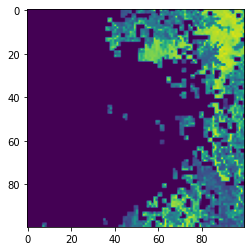

In [34]:
b = np.array(decoded_image)
plt.imshow(b[:,:,0:1])

The obtained data has, apart from spatial dimensions, also a temporal dimension of length 4, as there are 4 dates with data in the area. Here we show the data the first date.

The backend using this library should take this data and run it through its `aggregate_spatial` implementation.